In [1]:
# Importe
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client = Client("ETH")

# Part 1: Aufzeichnung lokales Erdbeben

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


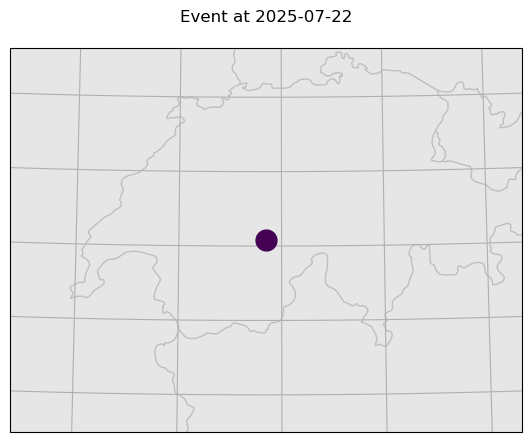

In [2]:
start_time = UTCDateTime("2025-07-22T15:51:20")

cat = client.get_events(start=start_time-3, end=start_time+3) # 10*86400 für längeren Zeitraum
cat.plot("local",label=None);

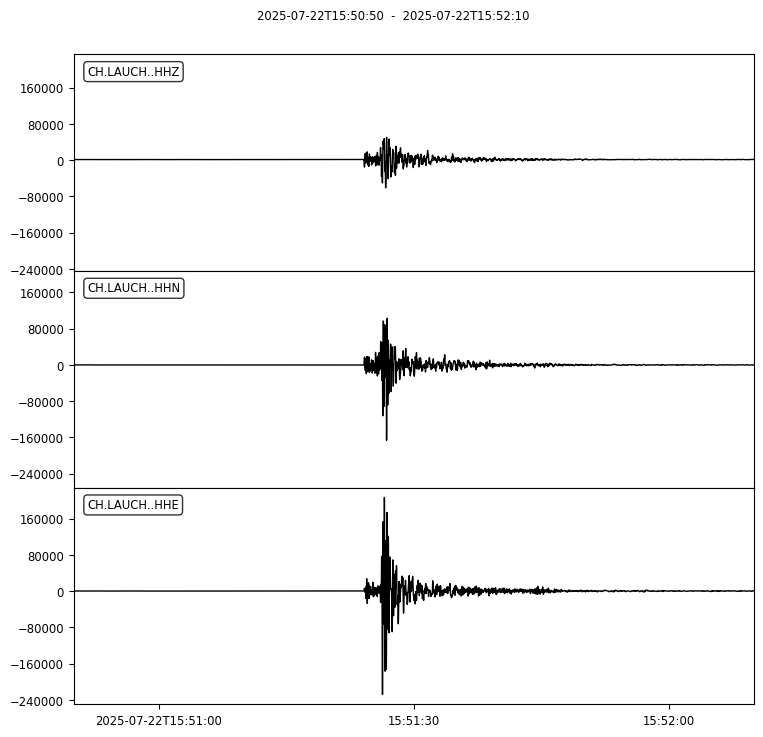

In [3]:
# Wir können Erdbebendaten von beliebigen Stationen und Seismometern herunterladen.

# Wir können einen Zeitpunkt eingeben von dem wir Daten laden wollen, z.B. nach einem Erdbeben in der Schweiz (Muerren BE, Magnitude 3.3)
start_time = UTCDateTime("2025-07-22T15:51:20")

# Mehr Information sind hier: http://seismo.ethz.ch/en/earthquakes/switzerland/eventpage.html?originId=%27c21pOmNoLmV0aHouc2VkL3NjMjBhZy9PcmlnaW4vTkxMLjIwMjUwODEyMTAzNTE5LjUxMDg5Mi4xMjAxMjU=%27&date_ch=2025-07-22&time_ch=17:51&region=Muerren%20BE&magnitude=3.3

# Und dann laden wir Daten von einem bestimmten Seismometer zu diesem Zeitpunkt herunter.
# Um den Seismometer zu identifizieren hat jeder Sensor einen Code aus
# Netzwerk (network) z.B. "CH" das Schweiz. Netwerk
# Station (station) z.B. "LAUCH"
# Kanal (channel) z.B. "HHZ" was der Aufzeichnung entlang der vertikalen Richtung/Komponente eines Breitbandseismometers entspricht
# Siehe auch https://networks.seismo.ethz.ch/en/networks/ch/

# Die Daten werden in einem Stream gespeichert,
# welcher ein oder mehrere Seismogramme, sowie Metadaten wie Informationen über den Seismometer und Zeiten, enthält
stream = client.get_waveforms(
    network="CH",
    station="LAUCH",
    location="*",
    channel="HH*",   #
    starttime=start_time-30,
    endtime=start_time+50,
    attach_response=True
)

# Wir können die Aufzeichnungen plotten und sehen die Bodenbewegung die vom Seismometer aufgezeichnet wurde
# entlang der vertikale (HHZ), Ost-West (HHE), und Nord-Süd (HHN) Komponente
stream.plot();

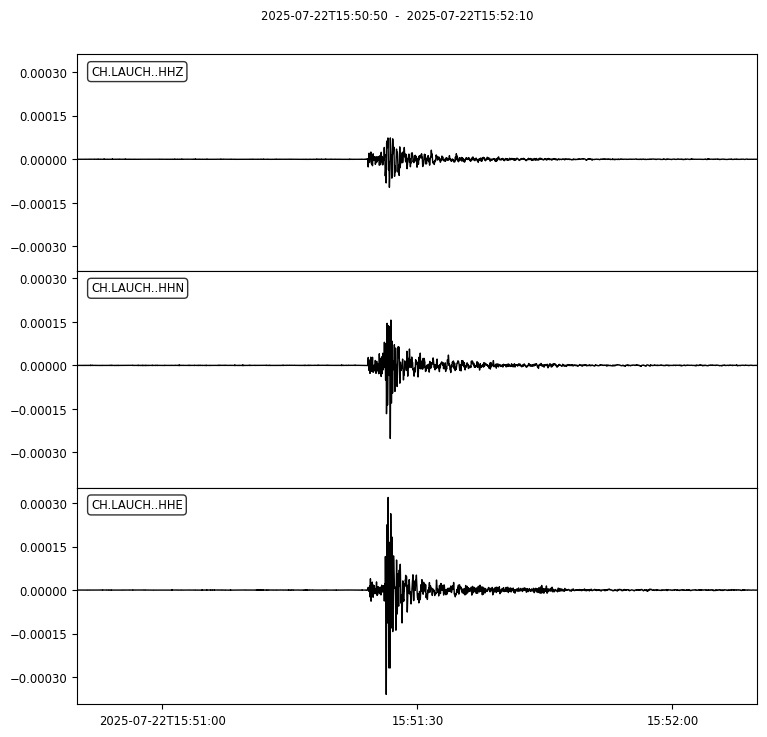

In [4]:
# Desweiteren bereiten wir die Daten vor, dieser Schritt wandelt die Aufzeichnungen des Seismometers in physikalische Einheiten um
# hier in Meter pro Sekunde (Velocity)
stream.remove_response(output="VEL")

# Wir plotten ausgewählte Seismogram
stream.plot();


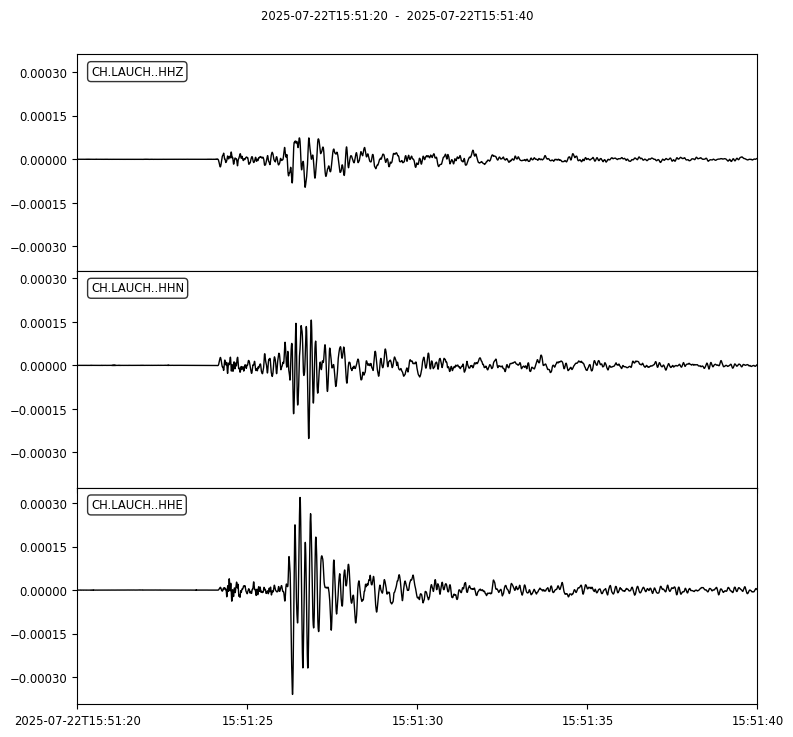

In [5]:
# Und das Seismogram noch kürzen
stream.trim(start_time, start_time+20);

# Und es erneut plotten
stream.plot();

# Frage: Welche Wellentypen können erkannt werden, und auf welcher Komponente?

In [6]:
def preprocess(time, seconds, network, station, channel,unit="VEL",filter=True):
    # Datendownload
    stream = Client("ETH").get_waveforms(
    network=network,
    station=station,
    location="*",
    channel=channel,   #
    starttime=time-30,
    endtime=time+seconds+30,
    attach_response=True
    )
    # Korrektur der Instrumentantwort / Übertragunsfunktion, Umwandlung in m/s
    stream.remove_response(output="VEL")
    if filter:
        # Bandpass filter 1-30 Hz, Signale mit anderen Frequenzen werden unterdrückt
        stream.filter("bandpass",freqmin=1,freqmax=30)
    # Kürzen, kombinieren einzelner Seismogramme (falls vorhanden) und Rückgabe
    return stream.trim(time, time+seconds).merge()

In [7]:
# Wir laden nun Daten von verschiedenen Stationen herunter, welche das Beben aufgezeichnet haben. 
##############################################################################################
time = UTCDateTime("2025-07-22T15:51:21") # Herdzeit Erdbeben 
seconds = 60  # 60 Sekunden Seismogram
component = "Z" # Bodenbewegung entlang Komponente Z: vertikal, N: Nord/Süd E: Ost/West;
# manchen Seismometer haben auch nur Z12 Komponenten
unit = "VEL" # Einheit der Daten "DISP" [m] "VEL" [m/s] ACC [m/s**2]
##############################################################################################


# Seisogramme der einzelnen Stationen werden gespeichert
trace_LAUCH = preprocess(time, seconds, "CH", "LAUCH", "HH"+component,unit)[0]
trace_SFRS = preprocess(time, seconds, "CH", "SFRS", "HG"+component,unit)[0]
trace_WIMIS = preprocess(time, seconds, "CH", "WIMIS", "HH"+component,unit)[0]
trace_FIESA = preprocess(time, seconds, "CH", "FIESA", "HH"+component,unit)[0]
trace_HASLI = preprocess(time, seconds, "CH", "HASLI", "HH"+component,unit)[0]
trace_GRIMS = preprocess(time, seconds, "CH", "GRIMS", "HH"+component,unit)[0]
trace_STSW2 = preprocess(time, seconds, "CH", "STSW2", "HG"+component,unit)[0]
trace_VANNI = preprocess(time, seconds, "CH", "VANNI", "HH"+component,unit)[0]
trace_JAUN = preprocess(time, seconds, "CH", "JAUN", "HH"+component,unit)[0]
trace_MMK = preprocess(time, seconds, "CH", "MMK", "HH"+component,unit)[0]
trace_DIX = preprocess(time, seconds, "CH", "DIX", "HH"+component,unit)[0]
trace_GRYON = preprocess(time, seconds, "CH", "GRYON", "HH"+component,unit)[0]
trace_DAGMA = preprocess(time, seconds, "CH", "DAGMA", "HH"+component,unit)[0]
trace_MOUTI = preprocess(time, seconds, "CH", "MOUTI", "HH"+component,unit)[0]
trace_PANIX = preprocess(time, seconds, "CH", "PANIX", "HH"+component,unit)[0]
trace_WILA = preprocess(time, seconds, "CH", "WILA", "HH"+component,unit)[0]
trace_SLE = preprocess(time, seconds, "CH", "SLE", "HH"+component,unit)[0]
trace_EMING = preprocess(time, seconds, "CH", "EMING", "HH"+component,unit)[0]

# Distanzen von Stationen zum Erdbebenherd für Erdbeben um 2025-07-22 15:51:21
distances = {"LAUCH":15.1,
             "SFRS":15.4,
             "WIMIS":22.0,
             "FIESA":23.2,
             "HASLI":33.3,
             "GRIMS":36.2,
             "STSW2":38.5,
             "VANNI":41.5,
             "JAUN":43.8,
             "MMK":55.2,
             "DIX":61.2,
             "GRYON":65.1,
             "DAGMA":77.7,
             "MOUTI":92.6,
             "PANIX":101.4,
             "WILA":126.1,
             "SLE":144.5,
             "EMING":168.3,
            }

# Seismogramme in Liste
traces = [
    trace_LAUCH, trace_SFRS, trace_WIMIS, trace_FIESA, trace_HASLI,
    trace_GRIMS, trace_STSW2, trace_VANNI, trace_JAUN,
    trace_MMK, trace_DIX, trace_GRYON, trace_DAGMA,
    trace_MOUTI, trace_PANIX , trace_WILA, trace_SLE, trace_EMING
]

## Aufgabe
Wir plotten die Seismogramme (bereits nach Distanz sortiert).

Beschreibe wie sich das Erdbebensignal auf verschiedenen Stationen unterscheidet? 

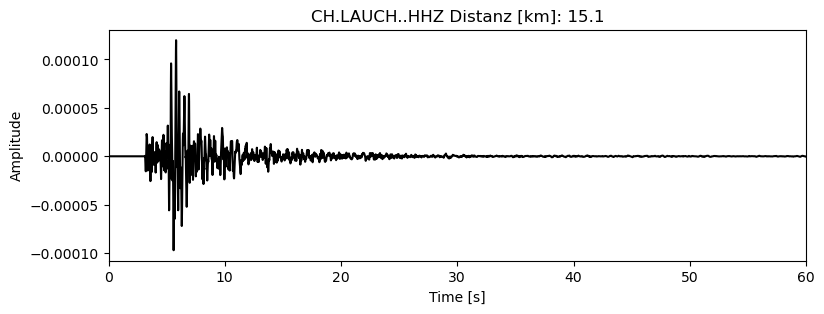

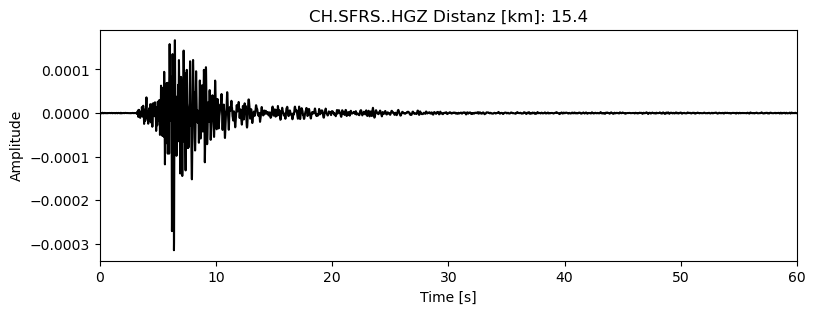

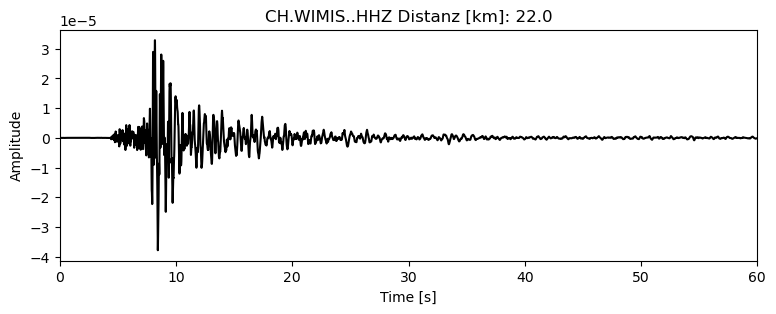

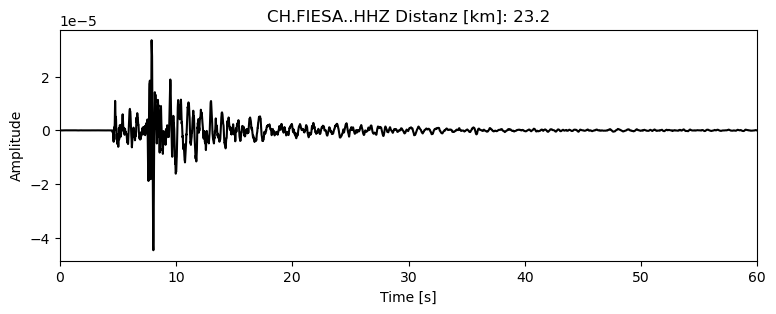

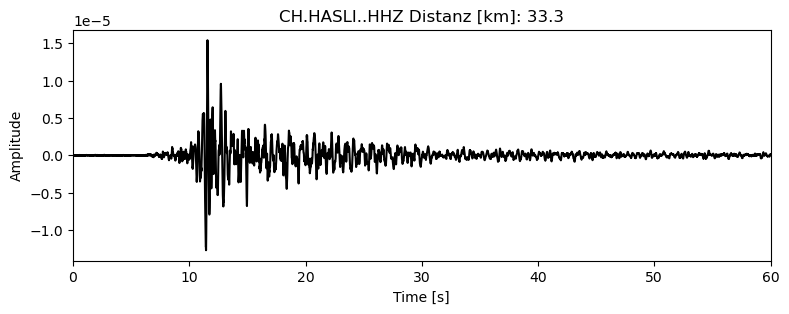

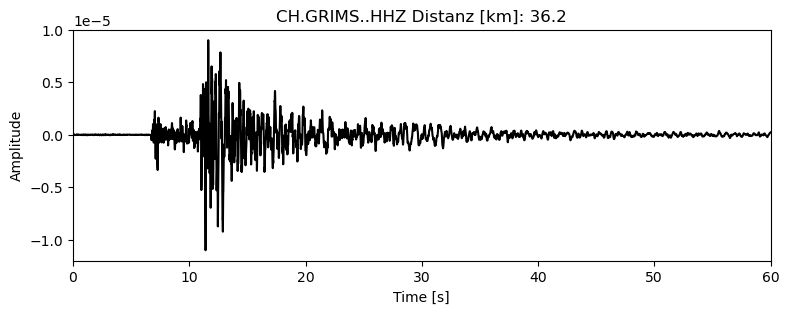

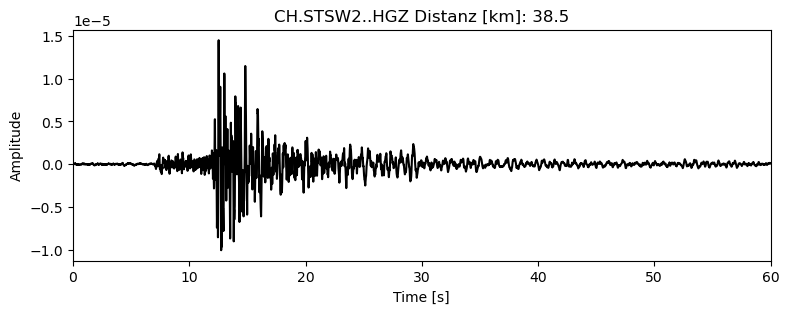

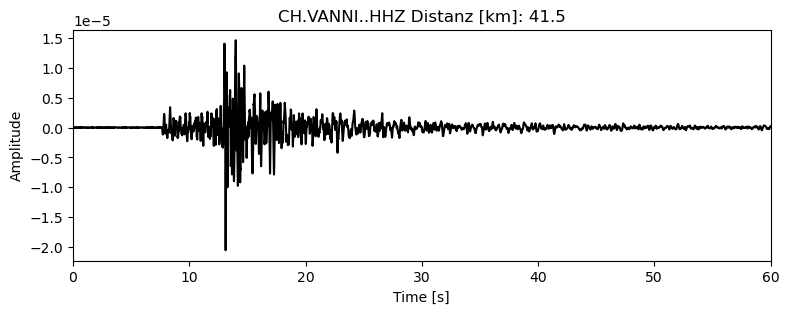

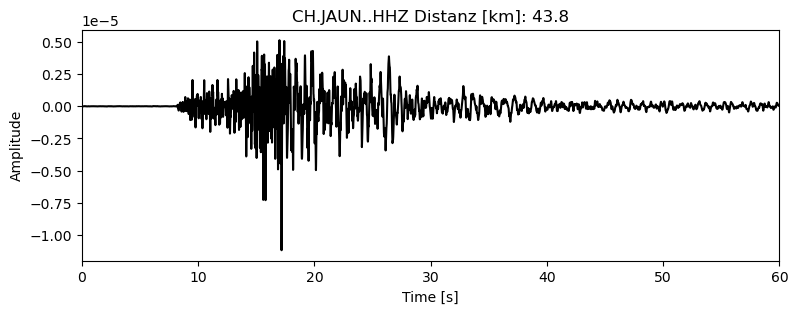

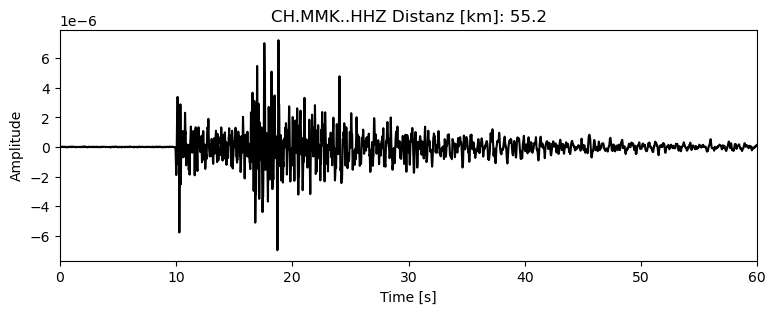

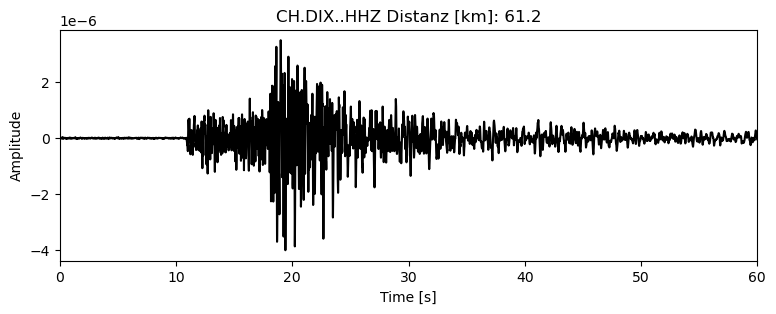

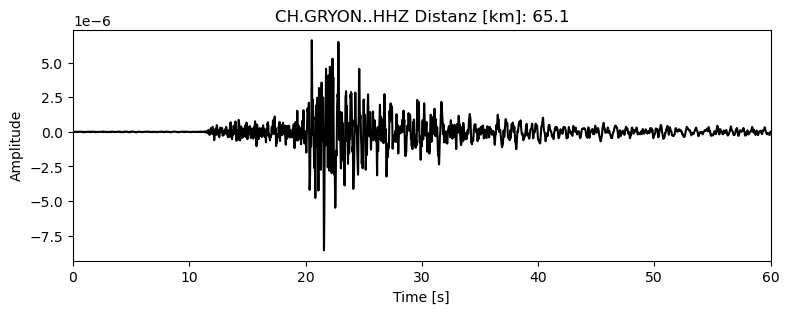

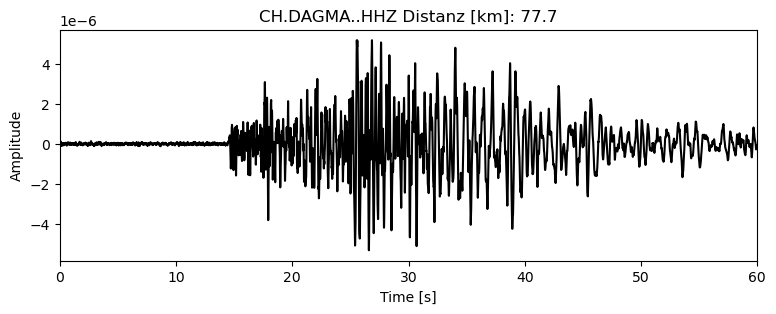

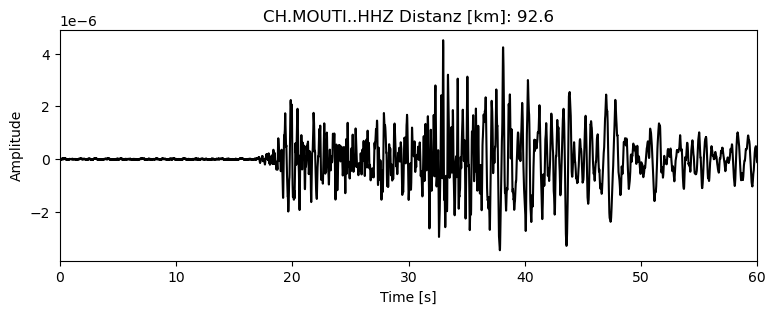

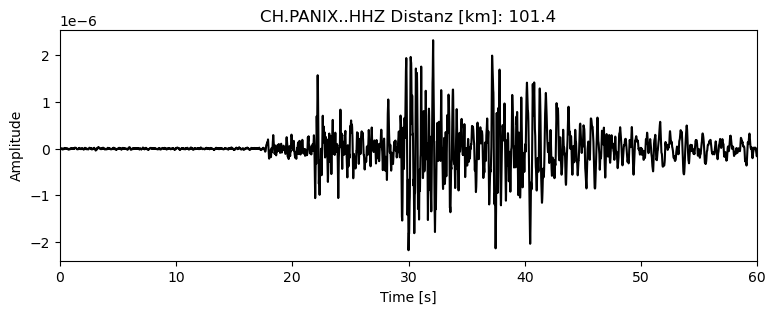

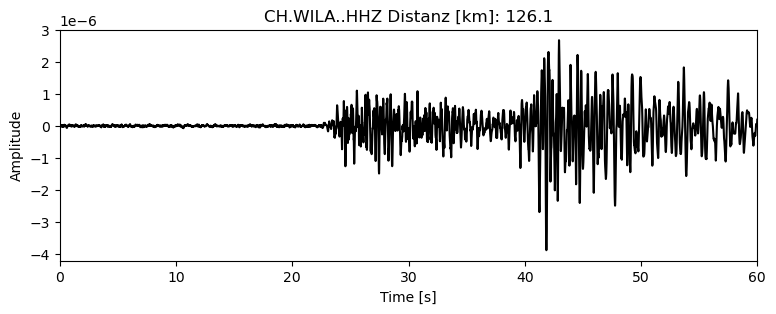

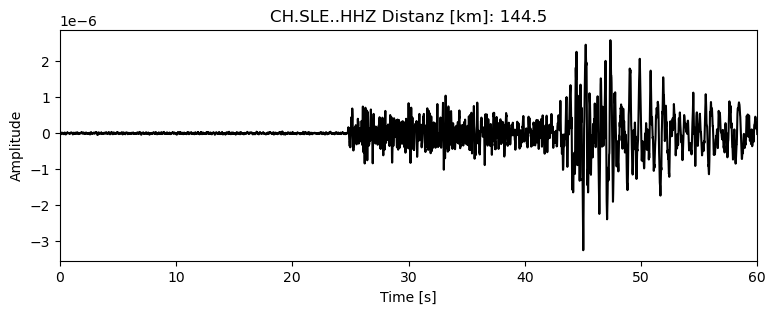

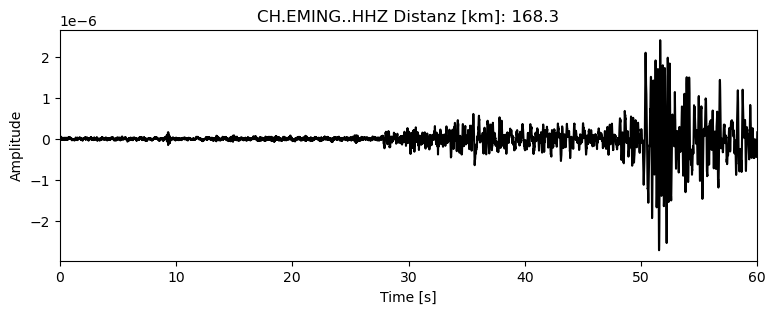

In [8]:
# Wir plotten die Seismogramme (bereits nach Distanz sortiert)

plt.close("all")
peak_amplitude_list = []  # TODO Lösung Max. Bodenbewegung in dieser Liste
distance_list = []  # TODO Lösung Max. Distanz in dieser Liste
for trace in traces:
    # Die aufgezeichnete Bodenbewegung ist in trace.data gespeichtert, die Zeitschritte in trace.times()
    plt.figure(figsize=(9,3))
    plt.plot(trace.times(),trace.data,color="k")
    distance = distances[trace.stats.station]
    plt.title(trace.id + " Distanz [km]: " + str(distance))
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.xlim(0,60)
    plt.show()
    
    peak_amplitude_list.append(np.max(np.abs(trace.data))) # TODO Lösung
    distance_list.append(distance) # TODO Lösung

## Aufgabe
In den Seismogramme ist sichtbar, dass die Amplitude der Bodenbewegung mit Distanz abnimmt

Bestimme bei von jedem Seismogram die Maximale Amplitude und erstelle eine Graphik in der die Maximale Amplitude gegen die Distanz aufgetragen wird

Frage: Wie nimmt die Amplitude mit Distanz ab? Welche Funktion beschreibt die Abnahme näherungsweise (zeichne Funktion in Graphik)?

In [9]:
# TODO: 
# plotte die maximale Bodenbeweung


# Plotte eine Funktion welche die Abnahme der Bodenbewegung annähert.
# plt.plot(...,... , lw=2, label='Amplitude ∝ ...',ls="--")


# Lösung



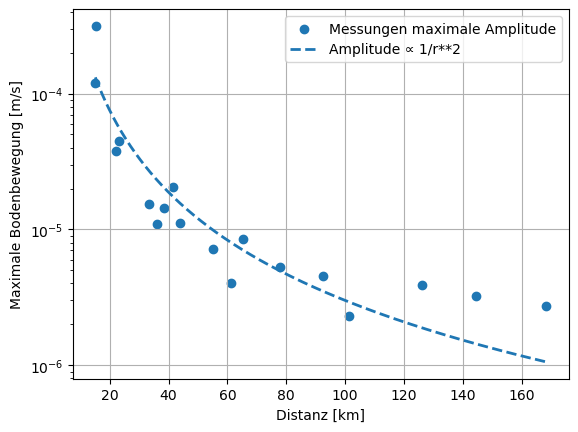

In [10]:
# Lösung
plt.scatter(distance_list,peak_amplitude_list,label="Messungen maximale Amplitude")
plt.yscale("log")
plt.ylabel("Maximale Bodenbewegung [m/s]")

plt.xlabel("Distanz [km]")

r = np.linspace(np.min(distance_list), np.max(distance_list), 1000)   # km
A = 1.0 / r**2                     # 1/distance
# linear plot
plt.plot(r, 0.03*A, lw=2, label='Amplitude ∝ 1/r**2',ls="--")
plt.legend()
plt.grid()
plt.show()


## Aufgabe
Neben der geometrischen Abminderung der Bodenbewegungen, welche Faktoren bestimmen die gemessenen Amplituden?

Lösung: i) Quelle: Bebenstärke, Fokalmechanismus, Frequenzgehalt Quelle
ii) Pfad: Anelastische Abminderung (Dämpfung und Streuung im Gestein)
iii) Station: Lokale Boden- und Gesteigseigenschaften,Topographie und lokale Struktur, Instrumentelle Effekte

## Aufgabe Magnitudenbestimmung

Nutze die gemessenen max. Amplituden um die Magnituden des Bebens zu bestimmen (Empirische Formel aus Vorlesung)

Typischer Weise wird die Magnitude mit der maximale Bodenverschiebung [m] berechnet, gemessen auf den horizontalen Komponenten.

In [11]:
# TODO
earthquake_magnitude = ...

print("Bestimmte Magnitude Erdbeben (median): " + str(earthquake_magnitude))
print("Bestimmte Magnitude Erdbeben SED: Mlhc 3.3 " )

#  SED nutzt eine etwas andere Magnitudenskala (Mlhc), 
# Die Mlhc Magnituden kala ist auf Daten aufgenommen in Schweiz kalibiert, und enthält verschiedene Korrekturen für lokale Effekte

Bestimmte Magnitude Erdbeben (median): Ellipsis
Bestimmte Magnitude Erdbeben SED: Mlhc 3.3 


In [12]:

# Lösung
distance_array = np.array(distance_list) 
amplitude_array_micrometer = np.array(peak_amplitude_list) * 1e6
magnitude_array = np.log10(amplitude_array_micrometer) -2.48 + 2.76 * np.log10(distance_array)
earthquake_magnitude = np.median(magnitude_array)

print("Bestimmte Magnitude Erdbeben (median): " + str(earthquake_magnitude))
print("Bestimmte Magnitude Erdbeben SED: Mlhc 3.3 " )



Bestimmte Magnitude Erdbeben (median): 3.240694791044444
Bestimmte Magnitude Erdbeben SED: Mlhc 3.3 


# Part 2: Aufzeichnung teleseismiches Erdbeben

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


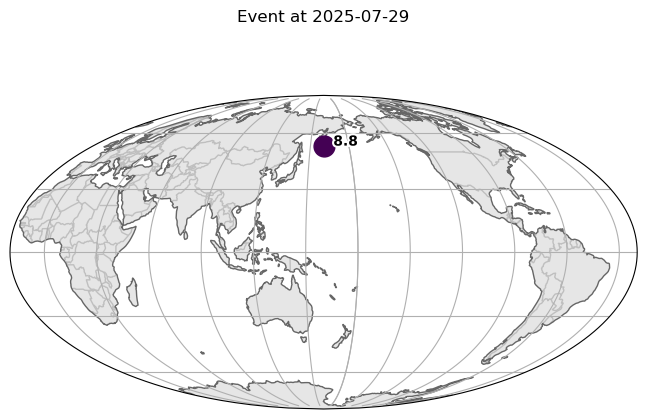

In [13]:
# Wir können einen Zeitpunkt eingeben von dem wir Daten laden wollen, z.B. die Zeit nach dem Mw 8.8 Kamchatka Erdbeben im July 2025
start_time = UTCDateTime("2025-07-29T23:24:51")

cat = Client("USGS").get_events(start=start_time-3, end=start_time+3) # +1*86400 für längeren Zeitraum
cat.plot();

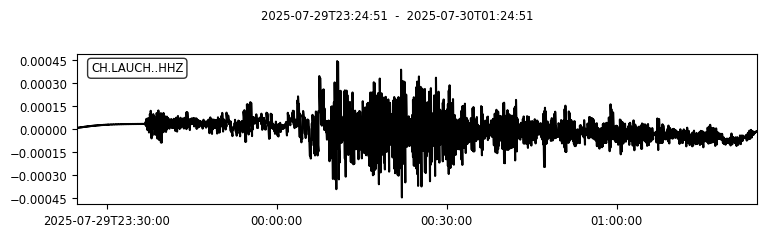

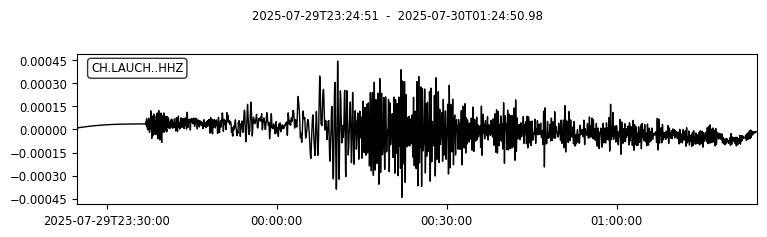

In [18]:
# Wir können einen Zeitpunkt eingeben von dem wir Daten laden wollen, z.B. die Zeit nach dem Mw 8.8 Kamchatka Erdbeben im July 2025
# und uns die aufgezeichnete Bodenbewegung auf derselben Station (LAUCH) wie oben anschauen.

start_time = UTCDateTime("2025-07-29T23:24:51")

# Und dann laden wir Daten von einem bestimmten Seismometer zu diesem Zeitpunkt herunter.
# Um den Seismometer zu identifizieren hat jeder Sensor einen Code aus
# Netzwerk (network) z.B. "CH" das Schweiz. Netwerk
# Station (station) z.B. "LAUCH"
# Kanal (channel) z.B. "HHZ" was der Aufzeichnung entlang der vertikalen Richtung/Komponente eines Breitbandseismometers entspricht
# Siehe auch https://networks.seismo.ethz.ch/en/networks/ch/

# Die Daten werden in einem Stream gespeichert,
# welcher ein oder mehrere Seismogramme, sowie Metadaten wie Informationen über den Seismometer und Zeiten, enthält

stream = client.get_waveforms(
    network="CH",
    station="LAUCH",
    location="*",
    channel="HHZ",   # Z: vertical components N: North components  E: East components
    starttime=start_time,
    endtime=start_time+2*3600,
    attach_response=True
).merge()

# Desweiteren bereiten wir die Daten vor, dieser Schritt wandelt die Aufzeichnungen des Seismometers in physikalische Einheiten um
# hier in Meter pro Sekunde (Velocity)
stream.remove_response(output="VEL")

# da die Aufzeichnungen lange sind, reduzieren wir die Abtastfrequenz (reduziert Datenvolumen)
stream.resample(50,no_filter=False)

# Letzendlich können wir das ausgewählte Seismogram plotten
stream.plot();


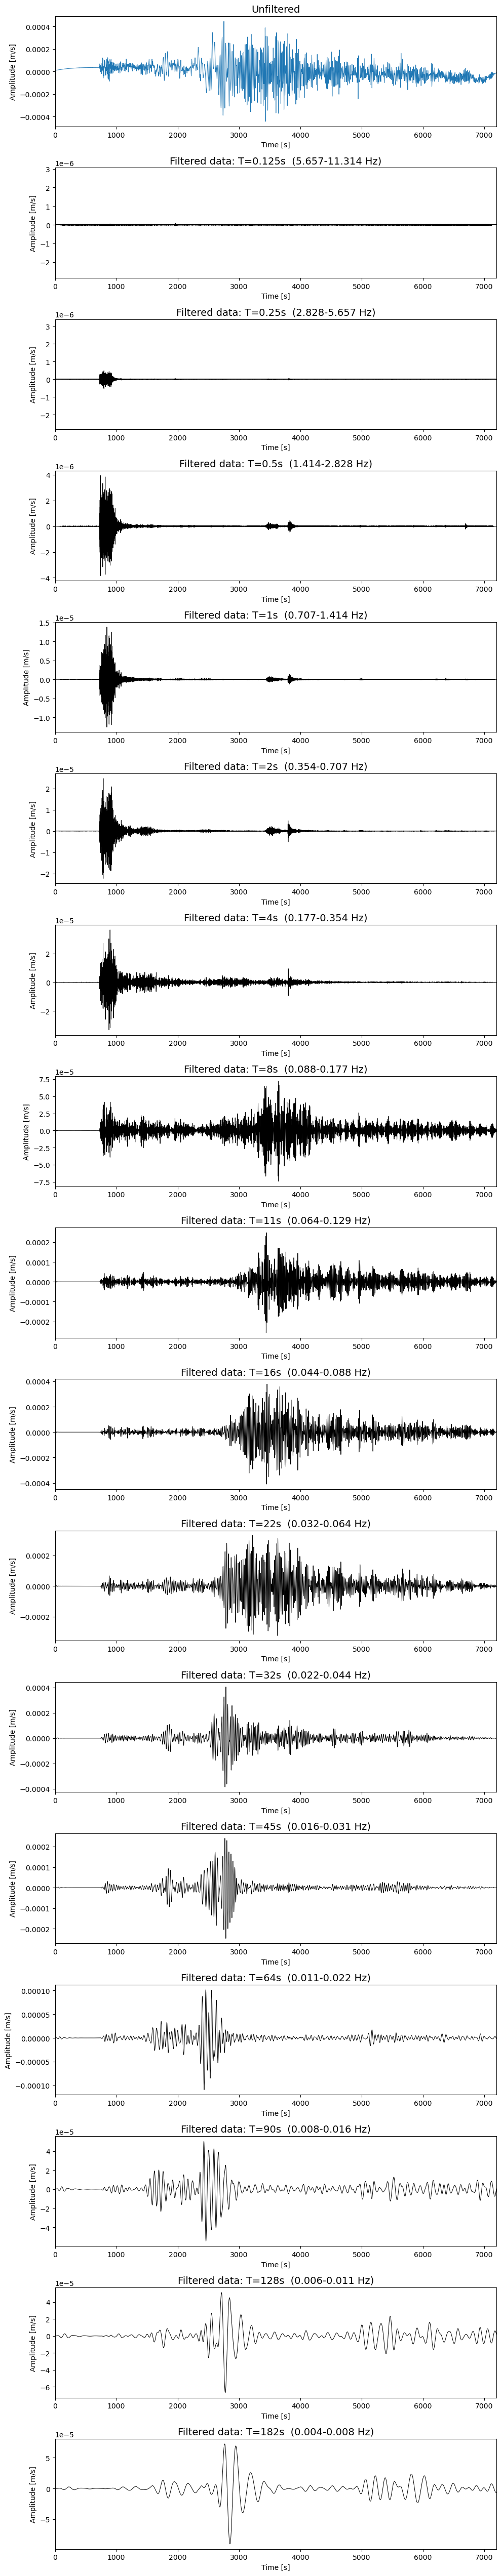

In [20]:
# Wir filtern das Seismogramme in verschiedenen Frequenzbändern (oder Perioden in Sekunden)
# Die Frequenzbänder beinhalten jeweils Signale mit folgenden Perioden   
periods = [182, 128, 90, 64, 45, 32, 22, 16, 11, 8, 4, 2, 1, 0.5, 0.25, 0.125][::-1]


stream_filt = stream.copy()
n = len(periods)+1

fig, axes = plt.subplots(n, 1, figsize=(10, n*3))
axes = axes.flatten()


# zunächst plotten wir die ungefilterten Daten
st_unf = stream_filt.copy()
st_unf.trim(start_time, start_time + 3*3600)
tr = st_unf[0]
t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
axes[0].plot(t, tr.data, lw=0.7)
axes[0].set_title("Unfiltered", fontsize=14)


# und nun filtern wir die Daten in verschiedene Frequenzbänder und plotten sie
for i, T in enumerate(periods,start=1):
    
    f_c = 1.0 / T  # central frequency
    fmin = f_c / np.sqrt(2) # lower cutoff frequency
    fmax = f_c * np.sqrt(2) # higher cutoff frequency

    st_band = stream_filt.copy()
    st_band.filter("bandpass", freqmin=fmin, freqmax=fmax,
                   corners=4)
    st_band.trim(start_time, start_time + 3*3600)

    tr = st_band[0]  # assuming one trace in stream
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    axes[i].plot(t, tr.data, lw=0.7,color="k")
    axes[i].set_title(f"Filtered data: T={T}s  ({fmin:.3f}-{fmax:.3f} Hz)", fontsize=14)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

for ax in axes:

    ax.set_xlim(t[0],t[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude [m/s]")

plt.tight_layout()
plt.show()

## Aufgabe: 
Typische Laufzeiten von Erdbebenwellen finden sich hier: https://www.usgs.gov/programs/earthquake-hazards/earthquake-travel-times

Von dem Diagram, lese ab wann welche Erdbenenwelle bei der Station LAUCH 
in der Schweiz ankommt
Dann zeichne die Phasen in das Seismogram um die einzelnen Einsätze zu bestimmen:

In [ ]:
plt.plot(t, tr.data, lw=0.7,color="tab:blue")

plt.axvline(1000)
